# Character Recognition

Task-

> Use this [dataset](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to train a
CNN. Use no other data source or pretrained networks, and explain your design choices during preprocessing, model building and training. Also, cite the sources you used to
borrow techniques. A test set will be provided later to judge the performance of your
classifier. Please save your model checkpoints.

## 1. Importing Modules

To develop and train a convolution neural network architecture, I have used PyTorch framework. Along with this OpenCV, numpy, pandas and matplotlib for image data handling and plotting are used. In this section we will importing all necessary modules.  

In [34]:
!pip install torchsummary

In [35]:
import random
import copy
import time 
import pandas as pd 
from PIL import Image
from torchsummary import summary


import torch
import torchvision
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

Following modules are python scripts imported from the same folder.

In [36]:
from data_py import dataset
from plotting_py import plot_loss, plot_images
from model_py import Net
from train_py import train_model, compute_accuracy

## 2. Data Preprocessing

The initial step is to create a dataframe of labels generated by carefully examining the dataset provided. This Labels.csv is mapped to image with its corresponding labels. This is necessary step for our model to understand classes. PyTorch also provides torchvision.data.ImageFolder() function to   

In [37]:
df = pd.read_csv('../input/training/Labels.csv')
df.head()

,Unnamed: 0,filenames,labels_code,labels
0,0,img001-001.png,img001,0
1,1,img001-002.png,img001,0
2,2,img001-003.png,img001,0
3,3,img001-004.png,img001,0
4,4,img001-007.png,img001,0


To change images into vector with normalisation and augmentation, following values are fetched to torchvision.transforms function. We perform: 
    
    - Random Rotations
    - Random Resizing and Cropping 
    - Change Image arrays to Tensor
    - Normalize

In [38]:
train_transforms = transforms.Compose([
                   transforms.RandomRotation(degrees=45),
                   transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                   transforms.ToTensor(),
                   transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])

               ])

Loading custom dataset that returns images and labels. 

In [39]:
LABELS='../input/training/Labels.csv' 
ROOT = '../input/training/train/train'

train_data = dataset(csv=LABELS, img_path=ROOT, transform = train_transforms)

Splitting the dataset into training and validation dataset. This is needed to keep track of how our model performs.

In [40]:
VALID_RATIO = 0.75
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,[n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = train_transforms

The final number of training and validation dataset.

In [41]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 1860
Number of validation examples: 620


Further we take our tensor datasets and put fetch them into Dataloader with certain batches(BATCH_SIZE). 

In [42]:
BATCH_SIZE = 256
train_iterator = data.DataLoader(train_data,batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,batch_size = BATCH_SIZE)

## 3. Images
Following are the images after preprocessing steps. The images are of (1200 x 900)px initially, but are processed to (64 x 64)px size and Rotated to 45 degrees. Since the images are png images they have 3 channels.

In [43]:
img_pil = Image.open('../input/training/train/train/img001-001.png')
print('Image Channels and Size: ', img_pil.mode, img_pil.size)

Image Channels and Size:  RGB (1200, 900)


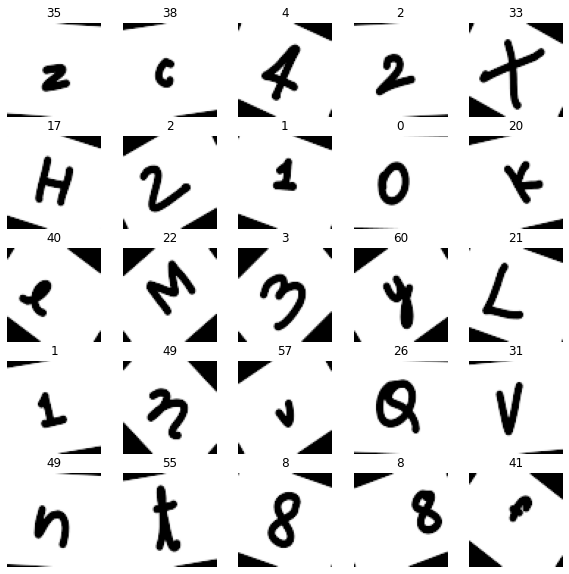

In [44]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = list(df['labels'].unique())
plot_images(images, labels, classes)

## 4. Hyper-parameters and model development

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100
model = Net(62)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device

device(type='cuda')

In [46]:
model

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [47]:
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

## 5. Training

In [48]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = train_model(model=model, num_epochs=num_epochs,
                                             train_iterator=train_iterator,
                                             valid_iterator=valid_iterator, 
                                             optimizer=optimizer,
                                             criterion=criterion, device=device)

Epoch: 1 	Training Loss: 0.017760 	Validation Loss: 0.019987
Validation loss decreased (inf --> 0.019987).  Saving model ...
Epoch: 2 	Training Loss: 0.017740 	Validation Loss: 0.020024
Epoch: 3 	Training Loss: 0.017722 	Validation Loss: 0.020039
Epoch: 4 	Training Loss: 0.017642 	Validation Loss: 0.019931
Validation loss decreased (0.019987 --> 0.019931).  Saving model ...
Epoch: 5 	Training Loss: 0.017406 	Validation Loss: 0.019480
Validation loss decreased (0.019931 --> 0.019480).  Saving model ...
Epoch: 6 	Training Loss: 0.017198 	Validation Loss: 0.019361
Validation loss decreased (0.019480 --> 0.019361).  Saving model ...
Epoch: 7 	Training Loss: 0.017137 	Validation Loss: 0.019242
Validation loss decreased (0.019361 --> 0.019242).  Saving model ...
Epoch: 8 	Training Loss: 0.017017 	Validation Loss: 0.019184
Validation loss decreased (0.019242 --> 0.019184).  Saving model ...
Epoch: 9 	Training Loss: 0.016752 	Validation Loss: 0.018719
Validation loss decreased (0.019184 --> 0.

## 6. Plotting Loss and Accuracy of model

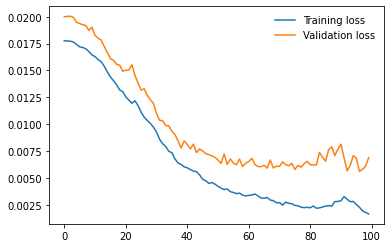

In [49]:
import matplotlib.pyplot as plt 
plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.legend(frameon=False)

In [50]:
def cal_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    model.train()


In [51]:
cal_accuracy(train_iterator, model, device)

Got 1506 / 1860 with accuracy 80.97


In [52]:
cal_accuracy(valid_iterator, model, device)

Got 397 / 620 with accuracy 64.03


## 7. Results

# Conclusion